# BDT creation

In [1]:
from datetime import timedelta
import h5py as h5
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp, kstwobign
import time

# the BDT framework I'll be using
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split

# helper functions to read in big data files
from read_h5_chunk import read_file_in_chunks
from mc_reader import MCReader

### Preparing data for BDT training

In [2]:
# get outkeys
all_keys = [
              ('ZTravel',       '<f8'),
              ('oneweight',     '<f8'),
              ('eff_oneweight', '<f8'),
              ('COGZ',          '<f8'),
              ('COGZSigma',     '<f8'),
              ('TrueEnergy',    '<f8'),
              ('TrueZenith',    '<f8'),
              ('TrueAzimuth',   '<f8'),
              ('PrimaryType',   '<f8'),
              ('RLogL',         '<f8'),
              ('RecoAzimuth',   '<f8'),
              ('RecoZenith',    '<f8'),
              ('QTot',          '<f8'),
              ('LDir_A',        '<f8'),
              ('NDirPulse_A',   '<f8'),
              ('NDirDOM_A',     '<f8'),
              ('NDirStr_A',     '<f8'),
              ('LDir_B',        '<f8'),
              ('NDirPulse_B',   '<f8'),
              ('NDirDOM_B',     '<f8'),
              ('NDirStr_B',     '<f8'),
              ('LDir_C',        '<f8'),
              ('NDirPulse_C',   '<f8'),
              ('NDirDOM_C',     '<f8'),
              ('NDirStr_C',     '<f8'),
              ('LDir_E',        '<f8'),
              ('NDirPulse_E',   '<f8'),
              ('NDirDOM_E',     '<f8'),
              ('NDirStr_E',     '<f8'),
              ('RecoAngSep',    '<f8'),
              ('BayesRatio',    '<f8')
             ]

dropkeys = ['oneweight', 'TrueEnergy', 'TrueZenith', 'TrueAzimuth', 'PrimaryType', 'RecoAzimuth', 
            'NDirDOM_C', 'NDirDOM_E', 'BayesRatio']

outkeys = [key for key, _ in all_keys if key not in dropkeys]
outkeys

['ZTravel',
 'eff_oneweight',
 'COGZ',
 'COGZSigma',
 'RLogL',
 'RecoZenith',
 'QTot',
 'LDir_A',
 'NDirPulse_A',
 'NDirDOM_A',
 'NDirStr_A',
 'LDir_B',
 'NDirPulse_B',
 'NDirDOM_B',
 'NDirStr_B',
 'LDir_C',
 'NDirPulse_C',
 'NDirStr_C',
 'LDir_E',
 'NDirPulse_E',
 'NDirStr_E',
 'RecoAngSep']

In [3]:
# macros
thin = 100

In [4]:
# read in fluxes
conv_flux_nancy_path = '../../../jlazar/solar/data/mc_dn_dz/sibyll23c_conv_l3_b_nancy_merged_holeice-0300_2.npy'
solar_flux_nancy_path = '../../../jlazar/solar/data/mc_dn_dz/SIBYLL2.3_pp_HillasGaisser_H4a_l3_b_nancy_merged_holeice-0300_2.npy'
conv_flux_genie_path = '../../../jlazar/solar/data/mc_dn_dz/sibyll23c_conv_l3_b_genie_merged_holeice-0300_2.npy'
solar_flux_genie_path = '../../../jlazar/solar/data/mc_dn_dz/SIBYLL2.3_pp_HillasGaisser_H4a_l3_b_genie_merged_holeice-0300_2.npy'

conv_flux_nancy = np.load(conv_flux_nancy_path)[::thin]
solar_flux_nancy = np.load(solar_flux_nancy_path)[::thin]
conv_flux_genie = np.load(conv_flux_genie_path)[::thin]
solar_flux_genie = np.load(solar_flux_genie_path)[::thin]
print('done')

done


In [5]:
# load genie (3 min)
print('genie...')
genie_path = '../../../jlazar/big_files/solar_atmospherics/l3_b_genie_merged_holeice-0300_2.h5'
start_time = time.time()
genie = read_file_in_chunks(genie_path, outkeys, thin=thin)
end_time = time.time()
duration = timedelta(seconds=end_time-start_time)
print('Finished in {0}'.format(duration))

genie...
Finished in 0:07:22.568544


In [6]:
# load nancy (1.5 hrs)
print('nancy...')
nancy_path = '../../../jlazar/big_files/solar_atmospherics/l3_b_nancy_merged_holeice-0300_2.h5'
start_time = time.time()
nancy = read_file_in_chunks(nancy_path, outkeys, thin=thin)
end_time = time.time()
duration = timedelta(seconds=end_time-start_time)
print('Finished in {0}'.format(duration))

nancy...
Finished in 3:06:45.012539


In [7]:
# load corsika
print('corsika...')
corsika_path = '../../../jlazar/big_files/solar_atmospherics/l3_b_corsika_merged_holeice-0300_2.h5'
start_time = time.time()
corsika = read_file_in_chunks(corsika_path, outkeys, thin=thin)
end_time = time.time()
duration = timedelta(seconds=end_time-start_time)
print('Finished in {0}'.format(duration))

corsika...
Finished in 2:30:14.927173


In [8]:
# convert to particle-specific dataframes
solar_df = pd.concat([pd.DataFrame(nancy), pd.DataFrame(genie)])
conv_df = pd.concat([pd.DataFrame(nancy), pd.DataFrame(genie)])
muon_df = pd.DataFrame(corsika)

# total flux
solar_flux = np.concatenate([solar_flux_nancy, solar_flux_genie])
conv_flux = np.concatenate([conv_flux_nancy, conv_flux_genie])

# normalized rate information
muon_df['norm-rate'] = muon_df['eff_oneweight'].values / np.sum(muon_df['eff_oneweight'])
solar_df['norm-rate'] = solar_df['eff_oneweight'] * solar_flux / np.sum(solar_df['eff_oneweight']*solar_flux)
conv_df['norm-rate'] = conv_df['eff_oneweight'] * conv_flux / np.sum(conv_df['eff_oneweight']*conv_flux)

# add in solar atmospheric info
solar_df['solar'] = 1
conv_df['solar'] = 0
muon_df['solar'] = 0

# add in muon info
solar_df['muon'] = 0
conv_df['muon'] = 0
muon_df['muon'] = 1

In [9]:
# combine all dataframes
data = pd.concat([muon_df, solar_df, conv_df])
data = data.reset_index(drop=True)
data = data.drop(columns=['eff_oneweight'])

print(data.shape)
data.head(50)

(2484596, 24)


,ZTravel,COGZ,COGZSigma,RLogL,RecoZenith,QTot,LDir_A,NDirPulse_A,NDirDOM_A,NDirStr_A,...,LDir_C,NDirPulse_C,NDirStr_C,LDir_E,NDirPulse_E,NDirStr_E,RecoAngSep,norm-rate,solar,muon
0,16.181664,195.756485,37.022224,33.874021,2.016922,9.025,NaN,1.0,1.0,1.0,...,111.748897,2.0,2.0,155.811024,9.0,2.0,0.000000e+00,8.185846e-08,0,1
1,30.323990,-464.713231,33.373538,11.684740,2.099566,15.725,142.279987,2.0,2.0,2.0,...,142.279987,7.0,3.0,186.073092,15.0,4.0,5.526237e-04,4.625277e-08,0,1
2,33.034170,-466.306037,52.105987,12.071475,1.492967,12.050,NaN,1.0,1.0,1.0,...,109.965718,2.0,2.0,222.568092,14.0,4.0,3.484113e-01,1.171941e-07,0,1
3,30.293069,-462.026478,37.073835,10.617668,2.625600,19.375,74.020239,3.0,3.0,1.0,...,129.686728,6.0,2.0,174.107589,23.0,3.0,9.590901e-02,8.185290e-09,0,1
4,56.637226,-425.194122,75.872357,10.144056,2.269713,28.125,NaN,0.0,0.0,0.0,...,NaN,0.0,0.0,295.763115,27.0,7.0,2.394320e-01,1.411252e-07,0,1
5,21.439992,-474.452936,31.537926,10.937935,1.453496,22.625,120.236210,3.0,3.0,2.0,...,124.219980,7.0,3.0,242.322049,23.0,6.0,3.945018e-02,3.551687e-08,0,1
6,59.588457,-387.863182,72.942464,11.232186,2.029082,17.125,NaN,1.0,1.0,1.0,...,136.738085,3.0,2.0,235.151063,15.0,4.0,NaN,7.954435e-08,0,1
7,8.496668,-467.580232,32.991506,14.477186,1.349810,11.700,NaN,1.0,1.0,1.0,...,124.079864,3.0,2.0,234.812807,12.0,5.0,5.199066e-02,2.247269e-07,0,1
8,68.273618,136.590663,84.983082,11.306642,2.348349,21.525,NaN,0.0,0.0,0.0,...,NaN,1.0,1.0,509.381928,25.0,11.0,1.125655e-01,3.767076e-11,0,1
9,8.964165,-456.980061,33.340407,11.488908,2.330539,12.950,149.786888,3.0,3.0,2.0,...,149.786888,5.0,2.0,237.530890,14.0,5.0,5.201683e-02,1.049830e-07,0,1


In [10]:
# number of nan entries
data.isna().sum()

ZTravel             0
COGZ                0
COGZSigma           0
RLogL               0
RecoZenith          0
QTot                0
LDir_A         851238
NDirPulse_A         0
NDirDOM_A           0
NDirStr_A           0
LDir_B         466930
NDirPulse_B         0
NDirDOM_B           0
NDirStr_B           0
LDir_C         226138
NDirPulse_C         0
NDirStr_C           0
LDir_E              0
NDirPulse_E         0
NDirStr_E           0
RecoAngSep       1505
norm-rate           0
solar               0
muon                0
dtype: int64

In [11]:
# split into training and test sets (for muon BDT)
X, y_muon, y_solar = data.drop(columns=['solar', 'muon']), data['muon'], data['solar']
X_train, X_test, y_train, y_test = train_test_split(X, y_muon)
train_weights, test_weights = X_train['norm-rate'], X_test['norm-rate']
X_train, X_test = X_train.drop(columns=['norm-rate']), X_test.drop(columns='norm-rate')

---
# First-pass BDT fitting

In [12]:
# instantiate bdt
muBDT = HistGradientBoostingClassifier(max_iter=5000, tol=5e-8, verbose=1)

# training
start_time = time.time()
muBDT.fit(X_train, y_train, train_weights)
end_time = time.time()
duration = timedelta(seconds=end_time-start_time)
print('Finished in {0}'.format(duration))

Binning 0.282 GB of training data: 1.573 s
Binning 0.031 GB of validation data: 0.311 s
Fitting gradient boosted rounds:
[1/5000] 1 tree, 31 leaves, max depth = 8, train loss: 0.61336, val loss: 0.61931, in 5.152s
[2/5000] 1 tree, 31 leaves, max depth = 8, train loss: 0.59484, val loss: 0.60111, in 5.000s
[3/5000] 1 tree, 31 leaves, max depth = 7, train loss: 0.57969, val loss: 0.58637, in 4.427s
[4/5000] 1 tree, 31 leaves, max depth = 8, train loss: 0.56598, val loss: 0.57280, in 3.434s
[5/5000] 1 tree, 31 leaves, max depth = 7, train loss: 0.55459, val loss: 0.56160, in 2.912s
[6/5000] 1 tree, 31 leaves, max depth = 8, train loss: 0.54417, val loss: 0.55127, in 2.216s
[7/5000] 1 tree, 31 leaves, max depth = 8, train loss: 0.53481, val loss: 0.54217, in 2.167s
[8/5000] 1 tree, 31 leaves, max depth = 7, train loss: 0.52682, val loss: 0.53432, in 3.882s
[9/5000] 1 tree, 31 leaves, max depth = 9, train loss: 0.51998, val loss: 0.52762, in 4.162s
[10/5000] 1 tree, 31 leaves, max depth = 8

[87/5000] 1 tree, 31 leaves, max depth = 12, train loss: 0.39556, val loss: 0.41199, in 4.269s
[88/5000] 1 tree, 31 leaves, max depth = 9, train loss: 0.39519, val loss: 0.41172, in 3.929s
[89/5000] 1 tree, 31 leaves, max depth = 10, train loss: 0.39485, val loss: 0.41149, in 3.830s
[90/5000] 1 tree, 31 leaves, max depth = 11, train loss: 0.39450, val loss: 0.41118, in 3.847s
[91/5000] 1 tree, 31 leaves, max depth = 12, train loss: 0.39419, val loss: 0.41100, in 3.690s
[92/5000] 1 tree, 31 leaves, max depth = 9, train loss: 0.39386, val loss: 0.41067, in 3.100s
[93/5000] 1 tree, 31 leaves, max depth = 11, train loss: 0.39358, val loss: 0.41041, in 3.021s
[94/5000] 1 tree, 31 leaves, max depth = 13, train loss: 0.39325, val loss: 0.41013, in 3.940s
[95/5000] 1 tree, 31 leaves, max depth = 12, train loss: 0.39287, val loss: 0.40987, in 4.871s
[96/5000] 1 tree, 31 leaves, max depth = 17, train loss: 0.39257, val loss: 0.40960, in 4.620s
[97/5000] 1 tree, 31 leaves, max depth = 9, train lo

[173/5000] 1 tree, 31 leaves, max depth = 8, train loss: 0.37733, val loss: 0.39815, in 3.843s
[174/5000] 1 tree, 31 leaves, max depth = 10, train loss: 0.37717, val loss: 0.39803, in 3.937s
[175/5000] 1 tree, 31 leaves, max depth = 14, train loss: 0.37705, val loss: 0.39794, in 3.896s
[176/5000] 1 tree, 31 leaves, max depth = 10, train loss: 0.37690, val loss: 0.39785, in 2.077s
[177/5000] 1 tree, 31 leaves, max depth = 12, train loss: 0.37675, val loss: 0.39774, in 4.176s
[178/5000] 1 tree, 31 leaves, max depth = 10, train loss: 0.37659, val loss: 0.39770, in 4.124s
[179/5000] 1 tree, 31 leaves, max depth = 14, train loss: 0.37650, val loss: 0.39762, in 4.266s
[180/5000] 1 tree, 31 leaves, max depth = 8, train loss: 0.37640, val loss: 0.39756, in 4.000s
[181/5000] 1 tree, 31 leaves, max depth = 13, train loss: 0.37629, val loss: 0.39748, in 4.119s
[182/5000] 1 tree, 31 leaves, max depth = 9, train loss: 0.37612, val loss: 0.39739, in 4.374s
[183/5000] 1 tree, 31 leaves, max depth = 1

[259/5000] 1 tree, 31 leaves, max depth = 13, train loss: 0.36783, val loss: 0.39266, in 3.947s
[260/5000] 1 tree, 31 leaves, max depth = 11, train loss: 0.36773, val loss: 0.39260, in 3.533s
[261/5000] 1 tree, 31 leaves, max depth = 14, train loss: 0.36764, val loss: 0.39257, in 3.818s
[262/5000] 1 tree, 31 leaves, max depth = 14, train loss: 0.36753, val loss: 0.39251, in 3.791s
[263/5000] 1 tree, 31 leaves, max depth = 14, train loss: 0.36742, val loss: 0.39243, in 3.732s
[264/5000] 1 tree, 31 leaves, max depth = 11, train loss: 0.36735, val loss: 0.39236, in 3.732s
[265/5000] 1 tree, 31 leaves, max depth = 12, train loss: 0.36727, val loss: 0.39232, in 3.781s
[266/5000] 1 tree, 31 leaves, max depth = 11, train loss: 0.36717, val loss: 0.39228, in 5.491s
[267/5000] 1 tree, 31 leaves, max depth = 19, train loss: 0.36709, val loss: 0.39220, in 3.865s
[268/5000] 1 tree, 31 leaves, max depth = 12, train loss: 0.36698, val loss: 0.39212, in 3.779s
[269/5000] 1 tree, 31 leaves, max depth 

[345/5000] 1 tree, 31 leaves, max depth = 16, train loss: 0.36094, val loss: 0.38867, in 3.866s
[346/5000] 1 tree, 31 leaves, max depth = 10, train loss: 0.36087, val loss: 0.38864, in 4.013s
[347/5000] 1 tree, 31 leaves, max depth = 12, train loss: 0.36076, val loss: 0.38860, in 4.112s
[348/5000] 1 tree, 31 leaves, max depth = 12, train loss: 0.36067, val loss: 0.38856, in 4.229s
[349/5000] 1 tree, 31 leaves, max depth = 14, train loss: 0.36057, val loss: 0.38857, in 4.461s
[350/5000] 1 tree, 31 leaves, max depth = 16, train loss: 0.36046, val loss: 0.38853, in 3.870s
[351/5000] 1 tree, 31 leaves, max depth = 8, train loss: 0.36040, val loss: 0.38848, in 3.943s
[352/5000] 1 tree, 31 leaves, max depth = 13, train loss: 0.36031, val loss: 0.38845, in 3.820s
[353/5000] 1 tree, 31 leaves, max depth = 9, train loss: 0.36022, val loss: 0.38843, in 3.985s
[354/5000] 1 tree, 31 leaves, max depth = 10, train loss: 0.36018, val loss: 0.38840, in 4.195s
[355/5000] 1 tree, 31 leaves, max depth = 

[431/5000] 1 tree, 31 leaves, max depth = 13, train loss: 0.35496, val loss: 0.38580, in 3.837s
[432/5000] 1 tree, 31 leaves, max depth = 13, train loss: 0.35492, val loss: 0.38577, in 4.691s
[433/5000] 1 tree, 31 leaves, max depth = 12, train loss: 0.35486, val loss: 0.38576, in 5.338s
[434/5000] 1 tree, 31 leaves, max depth = 9, train loss: 0.35478, val loss: 0.38571, in 3.792s
[435/5000] 1 tree, 31 leaves, max depth = 11, train loss: 0.35473, val loss: 0.38568, in 3.664s
[436/5000] 1 tree, 31 leaves, max depth = 14, train loss: 0.35470, val loss: 0.38566, in 2.219s
[437/5000] 1 tree, 31 leaves, max depth = 11, train loss: 0.35465, val loss: 0.38563, in 2.112s
[438/5000] 1 tree, 31 leaves, max depth = 13, train loss: 0.35459, val loss: 0.38563, in 2.141s
[439/5000] 1 tree, 31 leaves, max depth = 12, train loss: 0.35452, val loss: 0.38562, in 3.160s
[440/5000] 1 tree, 31 leaves, max depth = 8, train loss: 0.35447, val loss: 0.38563, in 4.314s
[441/5000] 1 tree, 31 leaves, max depth = 

[517/5000] 1 tree, 31 leaves, max depth = 10, train loss: 0.35033, val loss: 0.38371, in 3.967s
[518/5000] 1 tree, 31 leaves, max depth = 8, train loss: 0.35026, val loss: 0.38370, in 3.874s
[519/5000] 1 tree, 31 leaves, max depth = 9, train loss: 0.35020, val loss: 0.38367, in 4.184s
[520/5000] 1 tree, 31 leaves, max depth = 9, train loss: 0.35014, val loss: 0.38366, in 4.739s
[521/5000] 1 tree, 31 leaves, max depth = 12, train loss: 0.35009, val loss: 0.38362, in 3.762s
[522/5000] 1 tree, 31 leaves, max depth = 17, train loss: 0.35003, val loss: 0.38358, in 4.759s
[523/5000] 1 tree, 31 leaves, max depth = 12, train loss: 0.35000, val loss: 0.38358, in 3.254s
[524/5000] 1 tree, 31 leaves, max depth = 12, train loss: 0.34996, val loss: 0.38357, in 3.743s
[525/5000] 1 tree, 31 leaves, max depth = 13, train loss: 0.34992, val loss: 0.38355, in 3.692s
[526/5000] 1 tree, 31 leaves, max depth = 8, train loss: 0.34989, val loss: 0.38354, in 3.791s
[527/5000] 1 tree, 31 leaves, max depth = 11

[603/5000] 1 tree, 31 leaves, max depth = 15, train loss: 0.34598, val loss: 0.38159, in 4.474s
[604/5000] 1 tree, 31 leaves, max depth = 14, train loss: 0.34592, val loss: 0.38157, in 4.074s
[605/5000] 1 tree, 31 leaves, max depth = 14, train loss: 0.34586, val loss: 0.38151, in 4.237s
[606/5000] 1 tree, 31 leaves, max depth = 15, train loss: 0.34582, val loss: 0.38148, in 3.092s
[607/5000] 1 tree, 31 leaves, max depth = 13, train loss: 0.34578, val loss: 0.38148, in 2.518s
[608/5000] 1 tree, 31 leaves, max depth = 17, train loss: 0.34572, val loss: 0.38144, in 2.276s
[609/5000] 1 tree, 31 leaves, max depth = 14, train loss: 0.34566, val loss: 0.38142, in 4.276s
[610/5000] 1 tree, 31 leaves, max depth = 15, train loss: 0.34562, val loss: 0.38140, in 4.503s
[611/5000] 1 tree, 31 leaves, max depth = 11, train loss: 0.34556, val loss: 0.38138, in 4.557s
[612/5000] 1 tree, 31 leaves, max depth = 18, train loss: 0.34553, val loss: 0.38136, in 3.982s
[613/5000] 1 tree, 31 leaves, max depth 

[689/5000] 1 tree, 31 leaves, max depth = 16, train loss: 0.34192, val loss: 0.37990, in 4.212s
[690/5000] 1 tree, 31 leaves, max depth = 10, train loss: 0.34186, val loss: 0.37988, in 3.931s
[691/5000] 1 tree, 31 leaves, max depth = 12, train loss: 0.34182, val loss: 0.37986, in 3.970s
[692/5000] 1 tree, 31 leaves, max depth = 14, train loss: 0.34178, val loss: 0.37982, in 4.073s
[693/5000] 1 tree, 31 leaves, max depth = 14, train loss: 0.34172, val loss: 0.37980, in 3.959s
[694/5000] 1 tree, 31 leaves, max depth = 11, train loss: 0.34167, val loss: 0.37980, in 4.490s
[695/5000] 1 tree, 31 leaves, max depth = 16, train loss: 0.34162, val loss: 0.37980, in 4.693s
[696/5000] 1 tree, 31 leaves, max depth = 14, train loss: 0.34157, val loss: 0.37978, in 3.858s
[697/5000] 1 tree, 31 leaves, max depth = 14, train loss: 0.34152, val loss: 0.37976, in 3.859s
[698/5000] 1 tree, 31 leaves, max depth = 17, train loss: 0.34148, val loss: 0.37975, in 3.800s
[699/5000] 1 tree, 31 leaves, max depth 

[775/5000] 1 tree, 31 leaves, max depth = 14, train loss: 0.33833, val loss: 0.37826, in 3.973s
[776/5000] 1 tree, 31 leaves, max depth = 13, train loss: 0.33829, val loss: 0.37823, in 4.294s
[777/5000] 1 tree, 31 leaves, max depth = 11, train loss: 0.33826, val loss: 0.37821, in 4.055s
[778/5000] 1 tree, 31 leaves, max depth = 15, train loss: 0.33821, val loss: 0.37819, in 3.992s
[779/5000] 1 tree, 31 leaves, max depth = 13, train loss: 0.33819, val loss: 0.37817, in 3.865s
[780/5000] 1 tree, 31 leaves, max depth = 14, train loss: 0.33815, val loss: 0.37815, in 3.826s
[781/5000] 1 tree, 31 leaves, max depth = 11, train loss: 0.33812, val loss: 0.37815, in 4.143s
[782/5000] 1 tree, 31 leaves, max depth = 18, train loss: 0.33808, val loss: 0.37816, in 3.913s
[783/5000] 1 tree, 31 leaves, max depth = 11, train loss: 0.33804, val loss: 0.37815, in 4.754s
[784/5000] 1 tree, 31 leaves, max depth = 9, train loss: 0.33800, val loss: 0.37816, in 4.888s
[785/5000] 1 tree, 31 leaves, max depth =

[861/5000] 1 tree, 31 leaves, max depth = 9, train loss: 0.33512, val loss: 0.37691, in 3.852s
[862/5000] 1 tree, 31 leaves, max depth = 14, train loss: 0.33510, val loss: 0.37691, in 3.934s
[863/5000] 1 tree, 31 leaves, max depth = 16, train loss: 0.33506, val loss: 0.37690, in 4.046s
[864/5000] 1 tree, 31 leaves, max depth = 14, train loss: 0.33502, val loss: 0.37689, in 4.058s
[865/5000] 1 tree, 31 leaves, max depth = 16, train loss: 0.33498, val loss: 0.37687, in 4.090s
[866/5000] 1 tree, 31 leaves, max depth = 10, train loss: 0.33494, val loss: 0.37686, in 4.338s
[867/5000] 1 tree, 31 leaves, max depth = 14, train loss: 0.33491, val loss: 0.37685, in 3.925s
[868/5000] 1 tree, 31 leaves, max depth = 10, train loss: 0.33487, val loss: 0.37680, in 2.328s
[869/5000] 1 tree, 31 leaves, max depth = 12, train loss: 0.33482, val loss: 0.37677, in 4.107s
[870/5000] 1 tree, 31 leaves, max depth = 11, train loss: 0.33479, val loss: 0.37672, in 3.906s
[871/5000] 1 tree, 31 leaves, max depth =

[947/5000] 1 tree, 31 leaves, max depth = 14, train loss: 0.33215, val loss: 0.37563, in 4.686s
[948/5000] 1 tree, 31 leaves, max depth = 17, train loss: 0.33212, val loss: 0.37562, in 3.770s
[949/5000] 1 tree, 31 leaves, max depth = 13, train loss: 0.33208, val loss: 0.37561, in 3.960s
[950/5000] 1 tree, 31 leaves, max depth = 11, train loss: 0.33206, val loss: 0.37560, in 4.013s
[951/5000] 1 tree, 31 leaves, max depth = 13, train loss: 0.33201, val loss: 0.37556, in 4.017s
[952/5000] 1 tree, 31 leaves, max depth = 13, train loss: 0.33197, val loss: 0.37554, in 4.138s
[953/5000] 1 tree, 31 leaves, max depth = 15, train loss: 0.33195, val loss: 0.37552, in 5.378s
[954/5000] 1 tree, 31 leaves, max depth = 15, train loss: 0.33192, val loss: 0.37550, in 12.780s
[955/5000] 1 tree, 31 leaves, max depth = 19, train loss: 0.33190, val loss: 0.37549, in 4.958s
[956/5000] 1 tree, 31 leaves, max depth = 10, train loss: 0.33188, val loss: 0.37547, in 3.416s
[957/5000] 1 tree, 31 leaves, max depth

[1032/5000] 1 tree, 31 leaves, max depth = 9, train loss: 0.32949, val loss: 0.37449, in 4.854s
[1033/5000] 1 tree, 31 leaves, max depth = 17, train loss: 0.32945, val loss: 0.37449, in 4.557s
[1034/5000] 1 tree, 31 leaves, max depth = 14, train loss: 0.32942, val loss: 0.37445, in 2.965s
[1035/5000] 1 tree, 31 leaves, max depth = 15, train loss: 0.32939, val loss: 0.37445, in 2.144s
[1036/5000] 1 tree, 31 leaves, max depth = 11, train loss: 0.32936, val loss: 0.37442, in 3.284s
[1037/5000] 1 tree, 31 leaves, max depth = 13, train loss: 0.32932, val loss: 0.37440, in 4.285s
[1038/5000] 1 tree, 31 leaves, max depth = 8, train loss: 0.32928, val loss: 0.37438, in 4.148s
[1039/5000] 1 tree, 31 leaves, max depth = 13, train loss: 0.32924, val loss: 0.37436, in 4.387s
[1040/5000] 1 tree, 31 leaves, max depth = 15, train loss: 0.32920, val loss: 0.37435, in 4.111s
[1041/5000] 1 tree, 31 leaves, max depth = 17, train loss: 0.32918, val loss: 0.37435, in 4.002s
[1042/5000] 1 tree, 31 leaves, m

[1117/5000] 1 tree, 31 leaves, max depth = 11, train loss: 0.32694, val loss: 0.37346, in 4.158s
[1118/5000] 1 tree, 31 leaves, max depth = 16, train loss: 0.32691, val loss: 0.37344, in 4.338s
[1119/5000] 1 tree, 31 leaves, max depth = 14, train loss: 0.32689, val loss: 0.37343, in 3.887s
[1120/5000] 1 tree, 31 leaves, max depth = 17, train loss: 0.32686, val loss: 0.37342, in 3.391s
[1121/5000] 1 tree, 31 leaves, max depth = 11, train loss: 0.32684, val loss: 0.37341, in 3.837s
[1122/5000] 1 tree, 31 leaves, max depth = 10, train loss: 0.32682, val loss: 0.37340, in 3.801s
[1123/5000] 1 tree, 31 leaves, max depth = 16, train loss: 0.32680, val loss: 0.37337, in 3.897s
[1124/5000] 1 tree, 31 leaves, max depth = 11, train loss: 0.32677, val loss: 0.37336, in 3.810s
[1125/5000] 1 tree, 31 leaves, max depth = 13, train loss: 0.32674, val loss: 0.37334, in 4.700s
[1126/5000] 1 tree, 31 leaves, max depth = 16, train loss: 0.32670, val loss: 0.37332, in 5.261s
[1127/5000] 1 tree, 31 leaves,

[1202/5000] 1 tree, 31 leaves, max depth = 13, train loss: 0.32461, val loss: 0.37266, in 4.176s
[1203/5000] 1 tree, 31 leaves, max depth = 18, train loss: 0.32459, val loss: 0.37265, in 5.293s
[1204/5000] 1 tree, 31 leaves, max depth = 13, train loss: 0.32456, val loss: 0.37264, in 5.366s
[1205/5000] 1 tree, 31 leaves, max depth = 12, train loss: 0.32454, val loss: 0.37262, in 4.033s
[1206/5000] 1 tree, 31 leaves, max depth = 10, train loss: 0.32451, val loss: 0.37260, in 3.059s
[1207/5000] 1 tree, 31 leaves, max depth = 12, train loss: 0.32448, val loss: 0.37259, in 4.290s
[1208/5000] 1 tree, 31 leaves, max depth = 12, train loss: 0.32446, val loss: 0.37259, in 4.596s
[1209/5000] 1 tree, 31 leaves, max depth = 11, train loss: 0.32443, val loss: 0.37256, in 4.819s
[1210/5000] 1 tree, 31 leaves, max depth = 17, train loss: 0.32441, val loss: 0.37256, in 5.748s
[1211/5000] 1 tree, 31 leaves, max depth = 15, train loss: 0.32438, val loss: 0.37257, in 4.260s
[1212/5000] 1 tree, 31 leaves,

[1287/5000] 1 tree, 31 leaves, max depth = 11, train loss: 0.32244, val loss: 0.37183, in 4.305s
[1288/5000] 1 tree, 31 leaves, max depth = 11, train loss: 0.32241, val loss: 0.37182, in 4.205s
[1289/5000] 1 tree, 31 leaves, max depth = 14, train loss: 0.32239, val loss: 0.37181, in 3.762s
[1290/5000] 1 tree, 31 leaves, max depth = 9, train loss: 0.32237, val loss: 0.37181, in 3.981s
[1291/5000] 1 tree, 31 leaves, max depth = 13, train loss: 0.32234, val loss: 0.37179, in 3.810s
[1292/5000] 1 tree, 31 leaves, max depth = 13, train loss: 0.32231, val loss: 0.37175, in 3.491s
[1293/5000] 1 tree, 31 leaves, max depth = 11, train loss: 0.32228, val loss: 0.37174, in 3.955s
[1294/5000] 1 tree, 31 leaves, max depth = 13, train loss: 0.32226, val loss: 0.37175, in 3.848s
[1295/5000] 1 tree, 31 leaves, max depth = 17, train loss: 0.32224, val loss: 0.37175, in 4.170s
[1296/5000] 1 tree, 31 leaves, max depth = 19, train loss: 0.32221, val loss: 0.37174, in 3.930s
[1297/5000] 1 tree, 31 leaves, 

[1372/5000] 1 tree, 31 leaves, max depth = 10, train loss: 0.32017, val loss: 0.37096, in 4.134s
[1373/5000] 1 tree, 31 leaves, max depth = 12, train loss: 0.32014, val loss: 0.37093, in 3.982s
[1374/5000] 1 tree, 31 leaves, max depth = 12, train loss: 0.32012, val loss: 0.37089, in 3.490s
[1375/5000] 1 tree, 31 leaves, max depth = 14, train loss: 0.32009, val loss: 0.37087, in 4.026s
[1376/5000] 1 tree, 31 leaves, max depth = 15, train loss: 0.32008, val loss: 0.37087, in 4.302s
[1377/5000] 1 tree, 31 leaves, max depth = 17, train loss: 0.32005, val loss: 0.37086, in 3.819s
[1378/5000] 1 tree, 31 leaves, max depth = 11, train loss: 0.32002, val loss: 0.37082, in 3.813s
[1379/5000] 1 tree, 31 leaves, max depth = 15, train loss: 0.31999, val loss: 0.37080, in 3.929s
[1380/5000] 1 tree, 31 leaves, max depth = 15, train loss: 0.31996, val loss: 0.37079, in 3.847s
[1381/5000] 1 tree, 31 leaves, max depth = 14, train loss: 0.31994, val loss: 0.37077, in 4.006s
[1382/5000] 1 tree, 31 leaves,

[1457/5000] 1 tree, 31 leaves, max depth = 9, train loss: 0.31806, val loss: 0.37012, in 3.913s
[1458/5000] 1 tree, 31 leaves, max depth = 14, train loss: 0.31803, val loss: 0.37011, in 3.762s
[1459/5000] 1 tree, 31 leaves, max depth = 20, train loss: 0.31800, val loss: 0.37009, in 3.812s
[1460/5000] 1 tree, 31 leaves, max depth = 17, train loss: 0.31798, val loss: 0.37008, in 3.900s
[1461/5000] 1 tree, 31 leaves, max depth = 15, train loss: 0.31795, val loss: 0.37006, in 4.427s
[1462/5000] 1 tree, 31 leaves, max depth = 12, train loss: 0.31793, val loss: 0.37004, in 4.316s
[1463/5000] 1 tree, 31 leaves, max depth = 13, train loss: 0.31792, val loss: 0.37004, in 3.763s
[1464/5000] 1 tree, 31 leaves, max depth = 12, train loss: 0.31790, val loss: 0.37005, in 4.156s
[1465/5000] 1 tree, 31 leaves, max depth = 14, train loss: 0.31787, val loss: 0.37004, in 3.753s
[1466/5000] 1 tree, 31 leaves, max depth = 17, train loss: 0.31786, val loss: 0.37004, in 3.619s
[1467/5000] 1 tree, 31 leaves, 

[1542/5000] 1 tree, 31 leaves, max depth = 10, train loss: 0.31609, val loss: 0.36940, in 3.423s
[1543/5000] 1 tree, 31 leaves, max depth = 14, train loss: 0.31607, val loss: 0.36939, in 3.352s
[1544/5000] 1 tree, 31 leaves, max depth = 14, train loss: 0.31605, val loss: 0.36938, in 4.873s
[1545/5000] 1 tree, 31 leaves, max depth = 15, train loss: 0.31603, val loss: 0.36937, in 3.643s
[1546/5000] 1 tree, 31 leaves, max depth = 10, train loss: 0.31601, val loss: 0.36936, in 3.684s
[1547/5000] 1 tree, 31 leaves, max depth = 14, train loss: 0.31599, val loss: 0.36936, in 3.597s
[1548/5000] 1 tree, 31 leaves, max depth = 11, train loss: 0.31597, val loss: 0.36933, in 3.657s
[1549/5000] 1 tree, 31 leaves, max depth = 13, train loss: 0.31595, val loss: 0.36932, in 3.675s
[1550/5000] 1 tree, 31 leaves, max depth = 10, train loss: 0.31593, val loss: 0.36933, in 3.773s
[1551/5000] 1 tree, 31 leaves, max depth = 16, train loss: 0.31592, val loss: 0.36932, in 3.929s
[1552/5000] 1 tree, 31 leaves,

[1627/5000] 1 tree, 31 leaves, max depth = 13, train loss: 0.31417, val loss: 0.36863, in 4.414s
[1628/5000] 1 tree, 31 leaves, max depth = 14, train loss: 0.31416, val loss: 0.36864, in 3.755s
[1629/5000] 1 tree, 31 leaves, max depth = 15, train loss: 0.31413, val loss: 0.36862, in 3.697s
[1630/5000] 1 tree, 31 leaves, max depth = 17, train loss: 0.31410, val loss: 0.36861, in 3.614s
[1631/5000] 1 tree, 31 leaves, max depth = 15, train loss: 0.31408, val loss: 0.36859, in 3.523s
[1632/5000] 1 tree, 31 leaves, max depth = 14, train loss: 0.31405, val loss: 0.36858, in 3.503s
[1633/5000] 1 tree, 31 leaves, max depth = 15, train loss: 0.31404, val loss: 0.36857, in 3.905s
[1634/5000] 1 tree, 31 leaves, max depth = 18, train loss: 0.31402, val loss: 0.36857, in 3.709s
[1635/5000] 1 tree, 31 leaves, max depth = 15, train loss: 0.31401, val loss: 0.36856, in 4.338s
[1636/5000] 1 tree, 31 leaves, max depth = 12, train loss: 0.31398, val loss: 0.36856, in 3.680s
[1637/5000] 1 tree, 31 leaves,

[1712/5000] 1 tree, 31 leaves, max depth = 13, train loss: 0.31239, val loss: 0.36791, in 4.002s
[1713/5000] 1 tree, 31 leaves, max depth = 13, train loss: 0.31238, val loss: 0.36791, in 3.650s
[1714/5000] 1 tree, 31 leaves, max depth = 14, train loss: 0.31236, val loss: 0.36789, in 3.694s
[1715/5000] 1 tree, 31 leaves, max depth = 14, train loss: 0.31234, val loss: 0.36791, in 3.690s
[1716/5000] 1 tree, 31 leaves, max depth = 16, train loss: 0.31232, val loss: 0.36788, in 3.586s
[1717/5000] 1 tree, 31 leaves, max depth = 17, train loss: 0.31230, val loss: 0.36787, in 3.709s
[1718/5000] 1 tree, 31 leaves, max depth = 16, train loss: 0.31228, val loss: 0.36789, in 3.681s
[1719/5000] 1 tree, 31 leaves, max depth = 15, train loss: 0.31226, val loss: 0.36787, in 3.854s
[1720/5000] 1 tree, 31 leaves, max depth = 10, train loss: 0.31224, val loss: 0.36786, in 3.315s
[1721/5000] 1 tree, 31 leaves, max depth = 15, train loss: 0.31222, val loss: 0.36786, in 3.578s
[1722/5000] 1 tree, 31 leaves,

[1797/5000] 1 tree, 31 leaves, max depth = 15, train loss: 0.31073, val loss: 0.36747, in 2.082s
[1798/5000] 1 tree, 31 leaves, max depth = 15, train loss: 0.31070, val loss: 0.36747, in 2.158s
[1799/5000] 1 tree, 31 leaves, max depth = 15, train loss: 0.31068, val loss: 0.36747, in 3.770s
[1800/5000] 1 tree, 31 leaves, max depth = 14, train loss: 0.31067, val loss: 0.36746, in 3.631s
[1801/5000] 1 tree, 31 leaves, max depth = 13, train loss: 0.31064, val loss: 0.36745, in 3.879s
[1802/5000] 1 tree, 31 leaves, max depth = 15, train loss: 0.31063, val loss: 0.36746, in 3.795s
[1803/5000] 1 tree, 31 leaves, max depth = 11, train loss: 0.31062, val loss: 0.36744, in 3.748s
[1804/5000] 1 tree, 31 leaves, max depth = 16, train loss: 0.31058, val loss: 0.36743, in 4.009s
[1805/5000] 1 tree, 31 leaves, max depth = 19, train loss: 0.31057, val loss: 0.36742, in 3.670s
[1806/5000] 1 tree, 31 leaves, max depth = 8, train loss: 0.31055, val loss: 0.36742, in 3.431s
[1807/5000] 1 tree, 31 leaves, 

In [13]:
# helper function to separate signal and background events
def sig_bkg_split(X, y, weights):
    '''
    Splits X and y into signal and background sets with weights
    
    Parameters
    ----------
    - X (DataFrame): features
    - y (DataFrame): signal indicator (1 if signal, 0 if background)
    - weights (DataFrame): weights of events
    
    Returns
    -------
    - X_sig, X_bkg, w_sig, w_bkg (dataFrame tuple): data organized according to signal/background status 
    '''
    # get signal and background mask
    sig_mask = y.loc[y.values==1].index
    bkg_mask = y.loc[y.values==0].index

    return X.loc[sig_mask], X.loc[bkg_mask], weights.loc[sig_mask], weights.loc[bkg_mask]

In [14]:
# get training and testing background/signal sets
train_sig, train_bkg, train_sig_weights, train_bkg_weights = sig_bkg_split(X_train, y_train, train_weights)
test_sig, test_bkg, test_sig_weights, test_bkg_weights = sig_bkg_split(X_test, y_test, test_weights)

In [15]:
# get predicted probabilities
train_sig_probs = muBDT.predict_proba(train_sig)[:, 1]
train_bkg_probs = muBDT.predict_proba(train_bkg)[:, 1]
test_sig_probs = muBDT.predict_proba(test_sig)[:, 1]
test_bkg_probs = muBDT.predict_proba(test_bkg)[:, 1]

In [16]:
# plotting probability scores
def gen_hist(axs, xlabel, scale, train_sig_probs, train_bkg_probs, test_sig_probs, test_bkg_probs,
             train_sig_weights, train_bkg_weights, test_sig_weights, test_bkg_weights, decorate=True,
             *args, **kwargs):
    '''
    Plots signal probability histograms weighted according to weights.
    Parameters
    ----------
    - axs: list of matplotlib axes
        axes on which to plot
    - xlabel: str
        label for x-axis
    - scale: str 'lin' or 'log'
        scale for y-axis
    - train_sig_probs, ... test_bkg_probs: ndarrays
        BDT's predicted signal probability for each of train/test sig/bkg sets
    - train_sig_weights, ... test_bkg_weights: ndarrays
        weights associated with each train/test sig/bkg sets
    
    Returns
    -------
    - axs (matplotlib.pyplot.axes): axes with histogram attached
    '''

    # plot histograms
    axs[0].hist(train_sig_probs, weights=train_sig_weights, label='Muon samples', *args, **kwargs)
    axs[0].hist(train_bkg_probs, weights=train_bkg_weights, label='Neutrino samples', *args, **kwargs)
    if decorate:
        axs[0].set_title('Training sets')
        #axs[0].legend()
    
    axs[1].hist(test_sig_probs, weights=test_sig_weights, label='Muon samples', *args, **kwargs)
    axs[1].hist(test_bkg_probs, weights=test_bkg_weights, label='Neutrino samples', *args, **kwargs)
    if decorate:
        axs[1].set_title('Test sets')
        #axs[1].legend()
    
    # formatting
    axs[1].set_xlabel(xlabel)
    axs[0].set_yscale(scale)
    axs[1].set_yscale(scale)
    
    return axs

# plotting probability scores
def gen_hist_sing(ax, xlabel, scale, train_sig_probs, train_bkg_probs, test_sig_probs, test_bkg_probs,
             train_sig_weights, train_bkg_weights, test_sig_weights, test_bkg_weights, decorate=True,
             *args, **kwargs):
    '''
    Plots signal probability histograms weighted according to weights.
    Parameters
    ----------
    - ax: matplotlib axes
        axes on which to plot
    - xlabel: str
        label for x-axis
    - scale: str 'lin' or 'log'
        scale for y-axis
    - train_sig_probs, ... test_bkg_probs: ndarrays
        BDT's predicted signal probability for each of train/test sig/bkg sets
    - train_sig_weights, ... test_bkg_weights: ndarrays
        weights associated with each train/test sig/bkg sets
    
    Returns
    -------
    - ax (matplotlib.pyplot.axes): axes with histogram attached
    '''
    
    ax.hist(test_sig_probs, weights=test_sig_weights, label='Muon samples', *args, **kwargs)
    ax.hist(test_bkg_probs, weights=test_bkg_weights, label='Neutrino samples', *args, **kwargs)
    # formatting
    ax.set_xlabel(xlabel)
    ax.set_yscale(scale)
    
    return ax

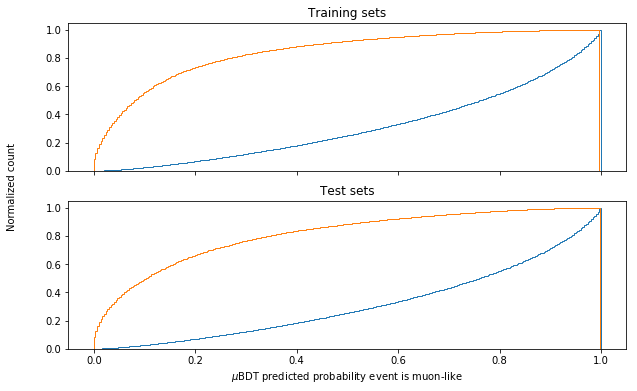

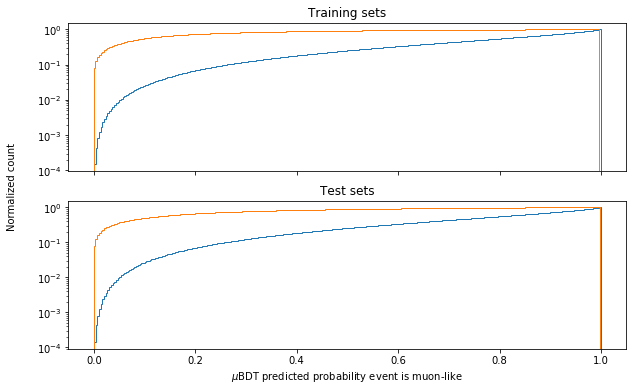

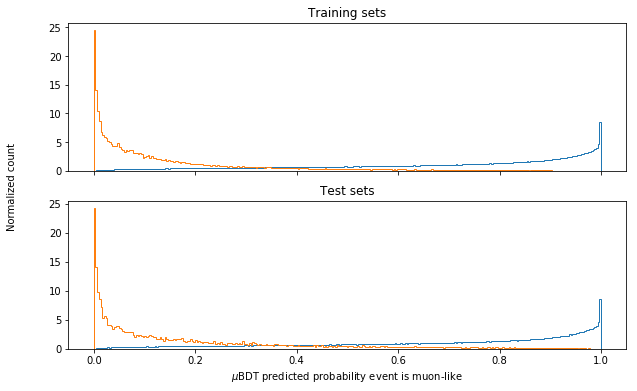

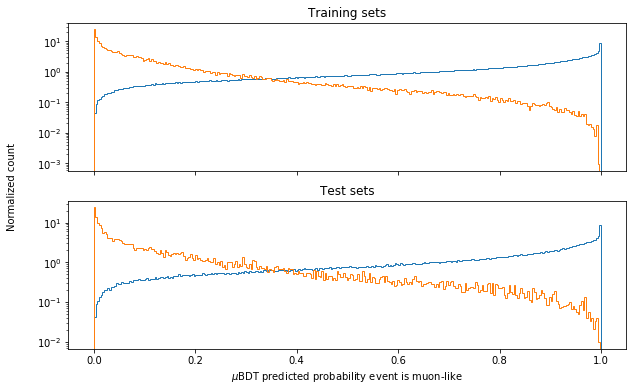

In [17]:
# plotting
for cum in [True, False]:
    for scale in ['linear', 'log']:
        fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
        axs = gen_hist(axs, '$\\mu$BDT predicted probability event is muon-like', scale,
                       train_sig_probs, train_bkg_probs, test_sig_probs, test_bkg_probs,
                       train_sig_weights, train_bkg_weights, test_sig_weights, test_bkg_weights, 
                       bins=300, histtype='step', density=True, cumulative=cum)
        
        fig.text(0.04, 0.5, 'Normalized count', va='center', rotation='vertical')
        plt.show()

In [18]:
# helper function to compute results of two-sample Kolmogorov-Smirnov test
# see https://stackoverflow.com/questions/40044375/how-to-calculate-the-kolmogorov-smirnov-statistic-between-two-weighted-samples
def ks_test_weighted(data1, data2, wei1, wei2, alpha=0.05):
    # compute k-s test statistic
    ix1 = np.argsort(data1)
    ix2 = np.argsort(data2)
    data1 = data1[ix1]
    data2 = data2[ix2]
    wei1 = wei1[ix1]
    wei2 = wei2[ix2]
    data = np.concatenate([data1, data2])
    cwei1 = np.hstack([0, np.cumsum(wei1)/sum(wei1)])
    cwei2 = np.hstack([0, np.cumsum(wei2)/sum(wei2)])
    cdf1we = cwei1[[np.searchsorted(data1, data, side='right')]]
    cdf2we = cwei2[[np.searchsorted(data2, data, side='right')]]
    statistic = np.max(np.abs(cdf1we - cdf2we))
    
    # compute p-value
    pvalue = 1 - kstwobign.cdf(statistic)
    
    return statistic, pvalue

In [19]:
# report result of K-S test
ks_sig = ks_test_weighted(train_sig_probs, test_sig_probs, 
                          train_sig_weights.reset_index(drop=True).values, 
                          test_sig_weights.reset_index(drop=True).values)
ks_bkg = ks_test_weighted(train_bkg_probs, test_bkg_probs, 
                          train_bkg_weights.reset_index(drop=True).values, 
                          test_bkg_weights.reset_index(drop=True).values)

print('muon K-S test statistic, p-value:', ks_sig)
print('neutrino K-S test statistic, p-value:', ks_bkg)

/home/jvillarreal/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
/home/jvillarreal/.local/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  from ipykernel import kernelapp as app


muon K-S test statistic, p-value: (0.004494199708250324, 1.0)
neutrino K-S test statistic, p-value: (0.0730103493674169, 1.0)


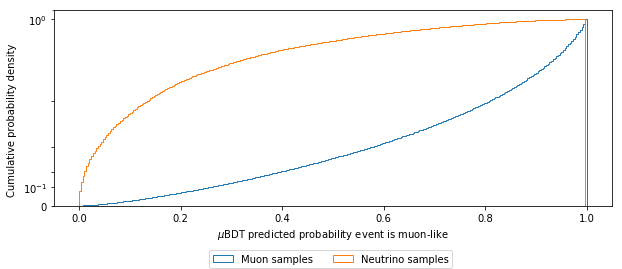

In [26]:
# proceedings plot
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

# plotting differential distribution
ax = gen_hist_sing(ax, '$\\mu$BDT predicted probability event is muon-like', 'symlog',
               train_sig_probs, train_bkg_probs, test_sig_probs, test_bkg_probs,
               train_sig_weights, train_bkg_weights, test_sig_weights, test_bkg_weights, 
               bins=300, histtype='step', density=True, cumulative=True)

# set yticks
ticks = np.concatenate(([0], np.logspace(-1, 0, 5)))
ax.set_yticks(ticks)
ax.set_yticklabels(['0', '$10^{-1}$', '', '', '', '$10^0$'])

# axis labels
fig.text(0.06, 0.5, 'Cumulative probability density', va='center', rotation='vertical')

fig.subplots_adjust(bottom=0.2)

# manual legend
legend_elements = [Patch(facecolor='white', edgecolor='C0', label='Muon samples'),
                   Patch(facecolor='white', edgecolor='C1', label='Neutrino samples')]

fig.legend(handles=legend_elements, ncol=2, loc=(0.335, 0.005))

plt.show()

# Correlation matrix

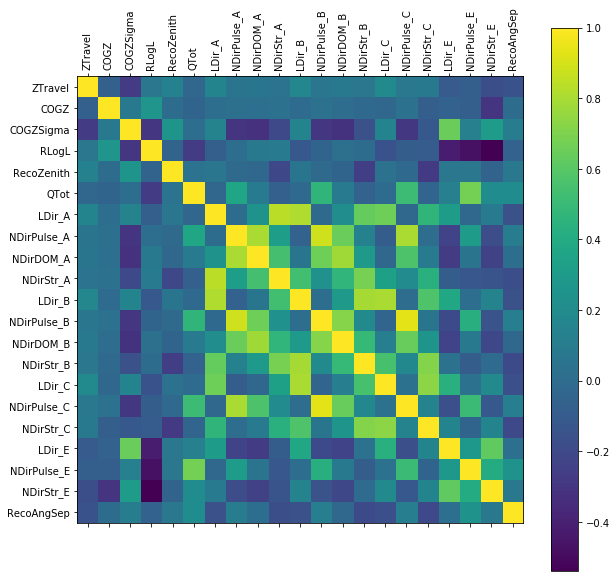

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
corr = ax.matshow(X.drop(columns='norm-rate').corr())

cb = plt.colorbar(corr, ax=ax)
ax.set_xticks(np.arange(0, 21))
ax.set_xticklabels(X.drop(columns='norm-rate').columns, rotation='vertical', minor=False)
ax.set_yticks(np.arange(0, 21))
ax.set_yticklabels(X.drop(columns='norm-rate').columns, minor=False)
plt.show()

In [72]:
X.columns

Index(['ZTravel', 'COGZ', 'COGZSigma', 'RLogL', 'RecoZenith', 'QTot', 'LDir_A',
       'NDirPulse_A', 'NDirDOM_A', 'NDirStr_A', 'LDir_B', 'NDirPulse_B',
       'NDirDOM_B', 'NDirStr_B', 'LDir_C', 'NDirPulse_C', 'NDirStr_C',
       'LDir_E', 'NDirPulse_E', 'NDirStr_E', 'RecoAngSep', 'norm-rate'],
      dtype='object')

In [76]:
X.shape

(2484596, 22)

In [88]:
data_final = X.copy()
data_final['muon'] = y_muon
data_final['solar'] = y_solar
data_final.head()

,ZTravel,COGZ,COGZSigma,RLogL,RecoZenith,QTot,LDir_A,NDirPulse_A,NDirDOM_A,NDirStr_A,...,LDir_C,NDirPulse_C,NDirStr_C,LDir_E,NDirPulse_E,NDirStr_E,RecoAngSep,norm-rate,muon,solar
0,16.181664,195.756485,37.022224,33.874021,2.016922,9.025,NaN,1.0,1.0,1.0,...,111.748897,2.0,2.0,155.811024,9.0,2.0,0.000000,8.185846e-08,1,0
1,30.323990,-464.713231,33.373538,11.684740,2.099566,15.725,142.279987,2.0,2.0,2.0,...,142.279987,7.0,3.0,186.073092,15.0,4.0,0.000553,4.625277e-08,1,0
2,33.034170,-466.306037,52.105987,12.071475,1.492967,12.050,NaN,1.0,1.0,1.0,...,109.965718,2.0,2.0,222.568092,14.0,4.0,0.348411,1.171941e-07,1,0
3,30.293069,-462.026478,37.073835,10.617668,2.625600,19.375,74.020239,3.0,3.0,1.0,...,129.686728,6.0,2.0,174.107589,23.0,3.0,0.095909,8.185290e-09,1,0
4,56.637226,-425.194122,75.872357,10.144056,2.269713,28.125,NaN,0.0,0.0,0.0,...,NaN,0.0,0.0,295.763115,27.0,7.0,0.239432,1.411252e-07,1,0


In [89]:
probs = muBDT.predict_proba(X.drop(columns='norm-rate'))
probs

array([[0.26904767, 0.73095233],
       [0.82212818, 0.17787182],
       [0.27599656, 0.72400344],
       ...,
       [0.94968088, 0.05031912],
       [0.93682825, 0.06317175],
       [0.95463742, 0.04536258]])

In [93]:
data_final['muon_prob'] = probs[:, 1]
data_final.head()

,ZTravel,COGZ,COGZSigma,RLogL,RecoZenith,QTot,LDir_A,NDirPulse_A,NDirDOM_A,NDirStr_A,...,NDirPulse_C,NDirStr_C,LDir_E,NDirPulse_E,NDirStr_E,RecoAngSep,norm-rate,muon,solar,muon_prob
0,16.181664,195.756485,37.022224,33.874021,2.016922,9.025,NaN,1.0,1.0,1.0,...,2.0,2.0,155.811024,9.0,2.0,0.000000,8.185846e-08,1,0,0.730952
1,30.323990,-464.713231,33.373538,11.684740,2.099566,15.725,142.279987,2.0,2.0,2.0,...,7.0,3.0,186.073092,15.0,4.0,0.000553,4.625277e-08,1,0,0.177872
2,33.034170,-466.306037,52.105987,12.071475,1.492967,12.050,NaN,1.0,1.0,1.0,...,2.0,2.0,222.568092,14.0,4.0,0.348411,1.171941e-07,1,0,0.724003
3,30.293069,-462.026478,37.073835,10.617668,2.625600,19.375,74.020239,3.0,3.0,1.0,...,6.0,2.0,174.107589,23.0,3.0,0.095909,8.185290e-09,1,0,0.867594
4,56.637226,-425.194122,75.872357,10.144056,2.269713,28.125,NaN,0.0,0.0,0.0,...,0.0,0.0,295.763115,27.0,7.0,0.239432,1.411252e-07,1,0,0.455943


In [94]:
data_final.to_csv('data_final.csv')

In [84]:
np.save('/data/user/jvillarreal/solar_atmospherics/bdt/train_index.npy', np.array(X_train.index))
np.save('/data/user/jvillarreal/solar_atmospherics/bdt/test_index.npy', np.array(X_test.index))